<a href="https://colab.research.google.com/github/kvasilisav/NLP-RL_girafe_assignments/blob/main/homeworks/hw1_word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Бонусное задание: word2vec на PyTorch

Как вы уже могли заметить, идея, лежащая в основе [word2vec](https://arxiv.org/pdf/1310.4546), достаточно общая. В данном задании вы реализуете его самостоятельно.

Дисклеймер: не стоит удивляться тому, что реализация от `gensim` (или аналоги) обучается быстрее и работает точнее. Она использует множество доработок и ускорений, а также достаточно эффективный код. Ваша задача добиться промежуточных результатов за разумное время.

P.s. Как ни странно, GPU в этом задании нам не потребуется.

__Requirements:__ if you're running locally, in the selected environment run the following command:

```pip install --upgrade nltk bokeh umap-learn```


In [ ]:
!pip install --upgrade nltk bokeh umap-learn

In [1]:
import itertools
import random
import string
from collections import Counter
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import umap
from IPython.display import clear_output
from matplotlib import pyplot as plt
from nltk.tokenize import WordPunctTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from tqdm.auto import tqdm as tqdma

In [2]:

# download the data:
!wget https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1 -O ./quora.txt -nc
# alternative download link: https://yadi.sk/i/BPQrUu1NaTduEw

--2025-04-02 11:19:47--  https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/p0t2dw6oqs6oxpd6zz534/quora.txt?rlkey=bjupppwua4zmd4elz8octecy9&dl=1 [following]
--2025-04-02 11:19:47--  https://www.dropbox.com/scl/fi/p0t2dw6oqs6oxpd6zz534/quora.txt?rlkey=bjupppwua4zmd4elz8octecy9&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca4058b1c39821e0d1fc48c6f15.dl.dropboxusercontent.com/cd/0/inline/CnDz1O7ixAC9BBcIDCN7QSsVpChBGpAVe0F8mj8UvROyXhr60pX5PGHG-1X1nSfaRUi_So_n6bnH9K3jlNgPuPcmTUMCreiKJYxaxauwIQoLUcJ1yMkQiGtEBjPIwVSajpU/file?dl=1# [following]
--2025-04-02 11:19:48--  https://uca4058b1c39821e0d1fc48c6f15.dl.dropboxusercontent.com/cd/0/inline/CnDz1O7ixAC

In [3]:
data = list(open("./quora.txt", encoding="utf-8"))
data[50]

"What TV shows or books help you read people's body language?\n"

Токенизация – первый шаг.
Тексты, с которыми мы работаем, включают в себя пунктуацию, смайлики и прочие нестандартные токены, так что простой `str.split` не подойдет.

Обратимся к `nltk` - библиотеку, нашла широкое применеие в области NLP.

In [4]:
tokenizer = WordPunctTokenizer()

print(tokenizer.tokenize(data[50]))

['What', 'TV', 'shows', 'or', 'books', 'help', 'you', 'read', 'people', "'", 's', 'body', 'language', '?']


In [5]:
data_tok = [
    tokenizer.tokenize(
        line.translate(str.maketrans("", "", string.punctuation)).lower()
    )
    for line in data
]
data_tok = [x for x in data_tok if len(x) >= 3]

Несколько проверок:

In [6]:
assert all(
    isinstance(row, (list, tuple)) for row in data_tok
), "please convert each line into a list of tokens (strings)"
assert all(
    all(isinstance(tok, str) for tok in row) for row in data_tok
), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all("a" <= x.lower() <= "z" for x in tok)
assert all(
    map(lambda l: not is_latin(l) or l.islower(), map(" ".join, data_tok))
), "please make sure to lowercase the data"

Ниже заданы константы ширины окна контекста и проведена предобработка для построения skip-gram модели.

In [7]:
min_count = 5
window_radius = 5

In [8]:
vocabulary_with_counter = Counter(chain.from_iterable(data_tok))

word_count_dict = dict()
for word, counter in vocabulary_with_counter.items():
    if counter >= min_count:
        word_count_dict[word] = counter

vocabulary = set(word_count_dict.keys())
del vocabulary_with_counter

In [9]:
word_to_index = {word: index for index, word in enumerate(vocabulary)}
index_to_word = {index: word for word, index in word_to_index.items()}

Пары `(слово, контекст)` на основе доступного датасета сгенерированы ниже.

In [10]:
context_pairs = []

for text in data_tok:
    for i, central_word in enumerate(text):
        context_indices = range(
            max(0, i - window_radius), min(i + window_radius, len(text))
        )
        for j in context_indices:
            if j == i:
                continue
            context_word = text[j]
            if central_word in vocabulary and context_word in vocabulary:
                context_pairs.append(
                    (word_to_index[central_word], word_to_index[context_word])
                )

print(f"Generated {len(context_pairs)} pairs of target and context words.")

Generated 40220313 pairs of target and context words.


In [11]:
context_pairs[0]

(26702, 19587)

#### Подзадача №1: subsampling
Для того, чтобы сгладить разницу в частоте встречаемсости слов, необходимо реализовать механизм subsampling'а.
Для этого вам необходимо реализовать функцию ниже.

Вероятность **исключить** слово из обучения (на фиксированном шаге) вычисляется как
$$
P_\text{drop}(w_i)=1 - \sqrt{\frac{t}{f(w_i)}},
$$
где $f(w_i)$ – нормированная частота встречаемости слова, а $t$ – заданный порог (threshold).

In [12]:
def subsample_frequent_words(word_count_dict, threshold=1e-5):
    """
    Calculates the subsampling probabilities for words based on their frequencies.

    This function is used to determine the probability of keeping a word in the dataset
    when subsampling frequent words. The method used is inspired by the subsampling approach
    in Word2Vec, where each word's frequency affects its probability of being kept.

    Parameters:
    - word_count_dict (dict): A dictionary where keys are words and values are the counts of those words.
    - threshold (float, optional): A threshold parameter used to adjust the frequency of word subsampling.
                                   Defaults to 1e-5.

    Returns:
    - dict: A dictionary where keys are words and values are the probabilities of keeping each word.

    Example:
    >>> word_counts = {'the': 5000, 'is': 1000, 'apple': 50}
    >>> subsample_frequent_words(word_counts)
    {'the': 0.028, 'is': 0.223, 'apple': 1.0}
    """

    ### MY CODE HERE
    all_counts = sum(word_count_dict.values())
    keep_prob_dict = {
        word: np.sqrt(threshold / (count/all_counts)) for word, count in word_count_dict.items()
    }
    ### MY CODE HERE
    return keep_prob_dict

#### Подзадача №2: negative sampling
Для более эффективного обучения необходимо не только предсказывать высокие вероятности для слов из контекста, но и предсказывать низкие для слов, не встреченных в контексте. Для этого вам необходимо вычислить вероятност использовать слово в качестве negative sample, реализовав функцию ниже.

В оригинальной статье предлагается оценивать вероятность слов выступать в качестве negative sample согласно распределению $P_n(w)$
$$
P_n(w) = \frac{U(w)^{3/4}}{Z},
$$

где $U(w)$ распределение слов по частоте (или, как его еще называют, по униграммам), а $Z$ – нормировочная константа, чтобы общая мера была равна $1$.

In [13]:
def get_negative_sampling_prob(word_count_dict):
    """
    Calculates the negative sampling probabilities for words based on their frequencies.

    This function adjusts the frequency of each word raised to the power of 0.75, which is
    commonly used in algorithms like Word2Vec to moderate the influence of very frequent words.
    It then normalizes these adjusted frequencies to ensure they sum to 1, forming a probability
    distribution used for negative sampling.

    Parameters:
    - word_count_dict (dict): A dictionary where keys are words and values are the counts of those words.

    Returns:
    - dict: A dictionary where keys are words and values are the probabilities of selecting each word
            for negative sampling.

    Example:
    >>> word_counts = {'the': 5000, 'is': 1000, 'apple': 50}
    >>> get_negative_sampling_prob(word_counts)
    {'the': 0.298, 'is': 0.160, 'apple': 0.042}
    """

    ### MY CODE HERE
    adjusted_counts = {word: count**0.75 for word, count in word_count_dict.items()}
    Z = sum(adjusted_counts.values())
    negative_sampling_prob_dict = {
        word: adj_count / Z for word, adj_count in adjusted_counts.items()
    }
    ### MY CODE HERE
    return negative_sampling_prob_dict

Для удобства, преобразуем полученные словари в массивы (т.к. все слова все равно уже пронумерованы).

In [14]:
keep_prob_dict = subsample_frequent_words(word_count_dict)
assert keep_prob_dict.keys() == word_count_dict.keys()

In [15]:
negative_sampling_prob_dict = get_negative_sampling_prob(word_count_dict)
assert negative_sampling_prob_dict.keys() == negative_sampling_prob_dict.keys()
assert np.allclose(sum(negative_sampling_prob_dict.values()), 1)

In [16]:
keep_prob_array = np.array(
    [keep_prob_dict[index_to_word[idx]] for idx in range(len(word_to_index))]
)
negative_sampling_prob_array = np.array(
    [
        negative_sampling_prob_dict[index_to_word[idx]]
        for idx in range(len(word_to_index))
    ]
)

Если все прошло успешно, функция ниже поможет вам с генерацией подвыборок (батчей).

In [17]:
def generate_batch_with_neg_samples(
    context_pairs,
    batch_size,
    keep_prob_array,
    word_to_index,
    num_negatives,
    negative_sampling_prob_array,
):
    batch = []
    neg_samples = []

    while len(batch) < batch_size:
        center, context = random.choice(context_pairs)
        if random.random() < keep_prob_array[center]:
            batch.append((center, context))
            neg_sample = np.random.choice(
                # range(len(negative_sampling_prob_array)),
                np.arange(len(negative_sampling_prob_array)),
                size=num_negatives,
                p=negative_sampling_prob_array,
            )
            neg_samples.append(neg_sample)
    batch = np.array(batch)
    neg_samples = np.vstack(neg_samples)
    return batch, neg_samples

In [18]:
batch_size = 4
num_negatives = 15
batch, neg_samples = generate_batch_with_neg_samples(
    context_pairs,
    batch_size,
    keep_prob_array,
    word_to_index,
    num_negatives,
    negative_sampling_prob_array,
)

In [19]:
neg_samples.shape

(4, 15)

In [20]:
batch.shape

(4, 2)

Наконец, время реализовать модель. Обращаем ваше внимание, использование линейных слоев (`nn.Linear`) далеко не всегда оправданно!

Напомним, что в случае negative sampling решается задача максимизации следующего функционала:

$$
\mathcal{L} = \log \sigma({\mathbf{v}'_{w_O}}^\top \mathbf{v}_{w_I}) + \sum_{i=1}^{k} \mathbb{E}_{w_i \sim P_n(w)} \left[ \log \sigma({-\mathbf{v}'_{w_i}}^\top \mathbf{v}_{w_I}) \right],
$$

где:
- $\mathbf{v}_{w_I}$ – вектор центрального слова $w_I$,
- $\mathbf{v}'_{w_O}$ – вектор слова из контекста $w_O$,
- $k$ – число negative samplesЮ,
- $P_n(w)$ – распределение negative samples, заданное выше,
- $\sigma$ – сигмоида.

In [29]:
class SkipGramModelWithNegSampling(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        ### MY CODE HERE
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size

        self.center_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)
        ### MY CODE HERE

    def forward(self, center_words, pos_context_words, neg_context_words):
        ### MY CODE HERE
        center_embeds = self.center_embeddings(center_words)  # [batch_size, embedding_dim] ->{unsqueze(2)}-> [batch_size, embedding_dim, 1]
        pos_context_embeds = self.context_embeddings(pos_context_words)  # [batch_size, embedding_dim]
        neg_context_embeds = self.context_embeddings(neg_context_words) # [batch_size, num_neg_samples, embedding_dim]

        pos_scores = torch.sum(center_embeds * pos_context_embeds, dim=1)
        neg_scores = torch.bmm(neg_context_embeds, center_embeds.unsqueeze(2)).squeeze(2) #[batch_size, num_neg_samples, 1] ->{squeze(2)}-> [batch_size, num_neg_samples]
        ### MY CODE HERE

        return pos_scores, neg_scores

In [30]:
device = torch.device("cpu")

In [31]:
vocab_size = len(word_to_index)
embedding_dim = 32
num_negatives = 15

model = SkipGramModelWithNegSampling(vocab_size, embedding_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.05)
lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=150)
criterion = nn.BCEWithLogitsLoss()

In [32]:
params_counter = 0
for weights in model.parameters():
    params_counter += weights.shape.numel()
assert params_counter == len(word_to_index) * embedding_dim * 2

In [33]:
def train_skipgram_with_neg_sampling(
    model,
    context_pairs, #список пар индексов вида (центральное слово, контекстное слово)
    keep_prob_array, #массив вероятностей оставить слово в обучении на фикс шаге
    word_to_index, #словарь {слово: инекс}
    batch_size,
    num_negatives,
    negative_sampling_prob_array, #массив вероятностей выбрать слово для негативного сэмпла
    steps,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    device=device,
):
    pos_labels = torch.ones(batch_size).to(device) #pos_labels = torch.ones_like(pos_scores).to(device)
    neg_labels = torch.zeros(batch_size, num_negatives).to(device) #neg_labels = torch.zeros_like(neg_scores).to(device)
    loss_history = []
    for step in tqdma(range(steps)):
        batch, neg_samples = generate_batch_with_neg_samples(
            context_pairs,
            batch_size,
            keep_prob_array,
            word_to_index,
            num_negatives,
            negative_sampling_prob_array,)
        center_words = torch.tensor([pair[0] for pair in batch], dtype=torch.long).to(device)
        # print(f'center words tensor shape = {center_words.shape}')
        pos_context_words = torch.tensor([pair[1] for pair in batch], dtype=torch.long).to(device)
        # print(f'positive context words tensor shape = {pos_context_words.shape}')
        neg_context_words = torch.tensor(neg_samples, dtype=torch.long).to(device)
        # print(f'negative context words tensor shape = {neg_context_words.shape}')

        optimizer.zero_grad()
        pos_scores, neg_scores = model(center_words, pos_context_words, neg_context_words)
        loss_pos = criterion(pos_scores, pos_labels)
        loss_neg = criterion(neg_scores, neg_labels)

        loss = loss_pos + loss_neg
        loss.backward()

        optimizer.step()

        loss_history.append(loss.item())
        lr_scheduler.step(loss_history[-1])

        if step % 100 == 0:
            # print(
            #     f"Step {step}, Loss: {np.mean(loss_history[-100:])}, learning rate: {lr_scheduler._last_lr}"
            # )
            if step != 0:
              clear_output(True)
              plt.plot(range(step + 1), loss_history)
              plt.title(f"Step {step}, Loss: {np.mean(loss_history[-100:])}, learning rate: {lr_scheduler._last_lr}")
              plt.show()

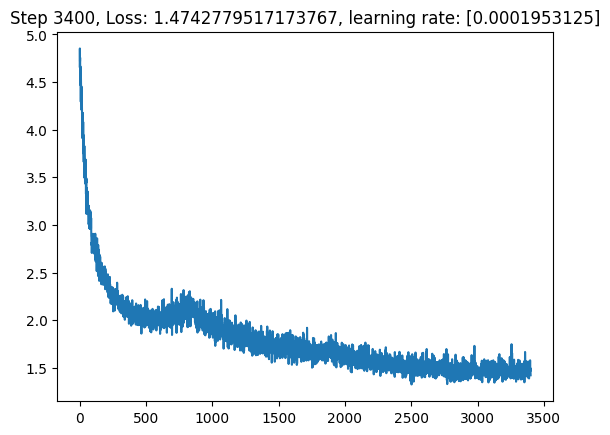

In [34]:
steps = 3500
batch_size = 512
train_skipgram_with_neg_sampling(
    model,
    context_pairs,
    keep_prob_array,
    word_to_index,
    batch_size,
    num_negatives,
    negative_sampling_prob_array,
    steps,
)

In [106]:
steps = 1
batch_size = 512
train_skipgram_with_neg_sampling(
    model,
    context_pairs,
    keep_prob_array,
    word_to_index,
    batch_size,
    num_negatives,
    negative_sampling_prob_array,
    steps,
)

  0%|          | 0/1 [00:00<?, ?it/s]

center words tensor shape = torch.Size([512])
positive context words tensor shape = torch.Size([512])
negative context words tensor shape = torch.Size([512, 15])
Step 0, Loss: 4.764842987060547, learning rate: [0.05]


Наконец, используйте полученную матрицу весов в качестве матрицы в векторными представлениями слов. Рекомендуем использовать для сдачи матрицу, которая отвечала за слова из контекста (т.е. декодера).

In [86]:
_model_parameters = model.parameters()
embedding_matrix_center = next(
    _model_parameters
).detach()  # Assuming that first matrix was for central word
embedding_matrix_context = next(
    _model_parameters
).detach()  # Assuming that second matrix was for context word

In [87]:
# def get_word_vector(word, embedding_matrix, word_to_index=word_to_index):
#     return embedding_matrix[word_to_index[word]]
#пофиксила чтобы считать нормированные вектора

def get_word_vector(word, embedding_matrix, word_to_index=word_to_index):
    vector = embedding_matrix[word_to_index[word]]
    return vector / torch.norm(vector, dim=0)

Простые проверки:

In [88]:
similarity_1 = F.cosine_similarity(
    get_word_vector("iphone", embedding_matrix_context)[None, :],
    get_word_vector("apple", embedding_matrix_context)[None, :],
)
similarity_2 = F.cosine_similarity(
    get_word_vector("iphone", embedding_matrix_context)[None, :],
    get_word_vector("dell", embedding_matrix_context)[None, :],
)
assert similarity_1 > similarity_2

In [89]:
similarity_1

tensor([0.4020])

In [90]:
similarity_2

tensor([0.1780])

In [91]:
similarity_1 = F.cosine_similarity(
    get_word_vector("windows", embedding_matrix_context)[None, :],
    get_word_vector("laptop", embedding_matrix_context)[None, :],
)
similarity_2 = F.cosine_similarity(
    get_word_vector("windows", embedding_matrix_context)[None, :],
    get_word_vector("macbook", embedding_matrix_context)[None, :],
)
assert similarity_1 > similarity_2

Наконец, взглянем на ближайшие по косинусной мере слова. Функция реализована ниже.

In [92]:
def find_nearest(word, embedding_matrix, word_to_index=word_to_index, k=10):
    word_vector = get_word_vector(word, embedding_matrix)[None, :]
    dists = F.cosine_similarity(embedding_matrix, word_vector)
    index_sorted = torch.argsort(dists)
    top_k = index_sorted[-k:]
    return [(index_to_word[x], dists[x].item()) for x in top_k.numpy()]

In [93]:
find_nearest("python", embedding_matrix_context, k=10)

[('precure', 0.649564802646637),
 ('situational', 0.6511328816413879),
 ('warhol', 0.6733914017677307),
 ('ammo', 0.6754786968231201),
 ('probabilities', 0.677514374256134),
 ('freelancer', 0.6845198273658752),
 ('kwh', 0.6876730918884277),
 ('20162017', 0.6901480555534363),
 ('coaster', 0.6953176856040955),
 ('python', 1.0)]

Также вы можете визуально проверить, как представлены в латентном пространстве часто встречающиеся слова.

In [94]:
top_k = 5000
_top_words = sorted([x for x in word_count_dict.items()], key=lambda x: x[1])[
    -top_k - 100 : -100
]  # ignoring 100 most frequent words
top_words = [x[0] for x in _top_words]
del _top_words

In [95]:
word_embeddings = torch.cat(
    [embedding_matrix_context[word_to_index[x]][None, :] for x in top_words], dim=0
).numpy()

In [96]:
import bokeh.models as bm
import bokeh.plotting as pl
from bokeh.io import output_notebook

output_notebook()


def draw_vectors(
    x,
    y,
    radius=10,
    alpha=0.25,
    color="blue",
    width=600,
    height=400,
    show=True,
    **kwargs,
):
    """draws an interactive plot for data points with auxilirary info on hover"""
    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({"x": x, "y": y, "color": color, **kwargs})

    fig = pl.figure(active_scroll="wheel_zoom", width=width, height=height)
    fig.scatter("x", "y", size=radius, color="color", alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show:
        pl.show(fig)
    return fig

In [97]:
embedding = umap.UMAP(n_neighbors=5).fit_transform(word_embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [98]:
draw_vectors(embedding[:, 0], embedding[:, 1], token=top_words)

figure(id='p1055', ...)

Для сдачи задания необходимо загрузить функции `subsample_frequent_words` и `get_negative_sampling_prob`, а также сгенерировать файл для посылки ниже и приложить в соответствующую задачу. Успехов!

In [100]:
# do not change the code in the block below
# __________start of block__________
import os
import json

assert os.path.exists(
    "words_subset.txt"
), "Please, download `words_subset.txt` and place it in the working directory"

with open("words_subset.txt") as iofile:
    selected_words = iofile.read().split("\n")


def get_matrix_for_selected_words(selected_words, embedding_matrix, word_to_index):
    word_vectors = []
    for word in selected_words:
        index = word_to_index.get(word, None)
        vector = [0.0] * embedding_matrix.shape[1]
        if index is not None:
            vector = embedding_matrix[index].numpy().tolist()
        word_vectors.append(vector)
    return word_vectors


# word_vectors = get_matrix_for_selected_words(
#     selected_words, embedding_matrix_context, word_to_index
# )

word_vectors = get_matrix_for_selected_words(
    selected_words, embedding_matrix_center, word_to_index
)

with open("submission_dict.json", "w") as iofile:
    json.dump(word_vectors, iofile)
print("File saved to `submission_dict.json`")
# __________end of block__________

File saved to `submission_dict.json`
